<a href="https://colab.research.google.com/github/mikful/audio-app-mf-ct/blob/master/nbs/19011_audio_app_model_v2_sotamodel_lwlrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio classification model training - Freesound 2019 Kaggle Competition dataset

* Model - pretrained fastai2 xresnet50 using fastai2 audio library
* Dataset - Curated Train Set from Kaggle Freesound 2019 Competition, multi-label 80 classes
* Test dataset - Test Set from Kaggle Freesound 2019 Competition, multi-label 80 classes

**fastai2_audio**

The additional requirements of the fastai2_audio package will be dealt with below, using a clone of the following repo:

https://github.com/rbracco/fastai2_audio


**For AWS setup look here and in fastai forum emails at Matt McClean email**
The demo was run and tested by deploying an SageMaker Notebook instance as per the instructions outlined [here] (https://forums.fast.ai/t/platform-amazon-sagemaker-aws/66020).

Note - the above link is only accessible as part of the ongoing fastai course for the time being.

In [ ]:
# See runtime gpu info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Aug 18 16:03:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download FSD 2019 Test dataset (NOW IN GOOGLE DRIVE)

https://zenodo.org/record/3612637

In [ ]:
# !wget https://zenodo.org/record/3612637/files/FSDKaggle2019.audio_train_curated.zip

In [ ]:
# !wget https://zenodo.org/record/3612637/files/FSDKaggle2019.audio_test.zip

In [ ]:
# !wget https://zenodo.org/record/3612637/files/FSDKaggle2019.meta.zip

let's put it all my google drive folder:

In [ ]:
# !mv "/content/FSDKaggle2019.audio_test.zip" "/content/drive/My Drive/Machine_Learning/My_Projects/19009 - Freesound 2019/audio_test.zip"

In [ ]:
# !mv "/content/FSDKaggle2019.audio_train_curated.zip" "/content/drive/My Drive/Machine_Learning/My_Projects/19009 - Freesound 2019/audio_train_curated.zip"

In [ ]:
# !mv "/content/FSDKaggle2019.meta.zip" "/content/drive/My Drive/Machine_Learning/My_Projects/19009 - Freesound 2019/meta.zip"

## Mount Google drive and Unzip data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's unzip the train and test sets data:

In [ ]:
# unzip train curated
!unzip -d '../content' -qq  "/content/drive/My Drive/Machine_Learning/My_Projects/19009 - Freesound 2019/audio_train_curated.zip"

replace ../content/FSDKaggle2019.audio_train_curated/310ef563.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
# unzip test
!unzip -d '../content' -qq  "/content/drive/My Drive/Machine_Learning/My_Projects/19009 - Freesound 2019/audio_test.zip"

replace ../content/FSDKaggle2019.audio_test/4409f798.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


and copy the label csv files:

In [ ]:
!unzip -d '../content' -qq  "/content/drive/My Drive/Machine_Learning/My_Projects/19009 - Freesound 2019/meta.zip"

replace ../content/FSDKaggle2019.meta/vocabulary.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import os
train_cur_files = os.listdir('/content/FSDKaggle2019.audio_train_curated')
test_files = os.listdir('/content/FSDKaggle2019.audio_test')

len(train_cur_files), len(test_files)

(4970, 4481)

## COLAB ONLY - INSTALL FASTAI2

In [ ]:
!pip install fastai2 -q

## Install and import the fastai2_audio library

We need to install the fastai2_audio library to the local kernel/environment for the analysis

Note the lack of `!pip` (that install to the root env) but rather standard `pip` (that installs to the current kernl/env)...

In [ ]:
#In Colab we need to run this as a shell command i.e. with '!' infront of 'pip'

!pip install git+https://github.com/mikful/fastai2_audio.git -q

In [ ]:
# Solving an OSError problem with Librosa SoundFile dependency (libsndfile)
# SageMaker/GCP Only

# !conda install -c conda-forge libsndfile --yes

In [ ]:
from fastai2.vision.all import *
from fastai2_audio.core.all import *
from fastai2_audio.augment.all import *

## Data Processing

The audio package analysis follows guidance given within: https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/07_Audio.ipynb

**Create Dataframes from csv files**

**Note: Delete Corrupted and empty files list in Kaggle Competition Note**

*The following 5 audio files in the curated train set have a wrong label, due to a bug in the file renaming process: f76181c4.wav, 77b925c2.wav, 6a1f682a.wav, c7db12aa.wav, 7752cc8a.wav*

*The audio file 1d44b0bd.wav in the curated train set was found to be corrupted (contains no signal) due to an error in format conversion.*

In [ ]:
# Create train_curated DataFrame

def create_train_curated_df(file, remove_files=[]):
    df_curated = pd.read_csv(file)
    df_curated['fname'] = '/content/FSDKaggle2019.audio_train_curated/' + df_curated['fname'] 
    df_curated.set_index('fname', inplace=True)
    df_curated.loc[remove_files]
    df_curated.drop(index=remove_files, inplace=True)
    df_curated.reset_index(inplace=True)
    return df_curated

# Create test DataFrame

def create_test_df(file, remove_files=[]):
    df_test = pd.read_csv(file)
    df_test['fname'] = '/content/FSDKaggle2019.audio_test/' + df_test['fname'] 
    df_test.set_index('fname', inplace=True)
    df_test.loc[remove_files]
    df_test.drop(index=remove_files, inplace=True)
    df_test.reset_index(inplace=True)
    return df_test

In [ ]:
# Create Curated training set df

# Remove corrupt and empty files as per Kaggle

remove_files = ['f76181c4.wav', '77b925c2.wav', '6a1f682a.wav', 'c7db12aa.wav', '7752cc8a.wav', '1d44b0bd.wav']
remove_files = ['/content/FSDKaggle2019.audio_train_curated/' + i for i in remove_files]
df_curated = create_train_curated_df('/content/FSDKaggle2019.meta/train_curated_post_competition.csv', remove_files=remove_files)
df_curated.head()

,fname,labels,freesound_id,license
0,/content/FSDKaggle2019.audio_train_curated/ac9e7a91.wav,Church_bell,65579,CC-BY-NC
1,/content/FSDKaggle2019.audio_train_curated/65ae847e.wav,Frying_(food),65583,CC Sampling+
2,/content/FSDKaggle2019.audio_train_curated/32ec2454.wav,Computer_keyboard,360502,CC0
3,/content/FSDKaggle2019.audio_train_curated/af7b5bab.wav,Scissors,360503,CC0
4,/content/FSDKaggle2019.audio_train_curated/7e8cd849.wav,Purr,65598,CC-BY


In [ ]:
# Create Curated training set df

# Remove corrupt and empty files as per Kaggle
df_test = create_test_df('/content/FSDKaggle2019.meta/test_post_competition.csv')
df_test.head()

,fname,labels,usage,freesound_id,license
0,/content/FSDKaggle2019.audio_test/d527f12d.wav,Chewing_and_mastication,Private,327681,CC-BY-NC
1,/content/FSDKaggle2019.audio_test/4030a4f2.wav,Cupboard_open_or_close,Public,180226,CC-BY
2,/content/FSDKaggle2019.audio_test/e106401c.wav,Purr,Private,155651,CC0
3,/content/FSDKaggle2019.audio_test/8d22f633.wav,Waves_and_surf,Private,360450,CC0
4,/content/FSDKaggle2019.audio_test/2d5dcc5d.wav,"Tap,Drawer_open_or_close",Public,245765,CC0


In [ ]:
df_curated.describe()

,freesound_id
count,4964.000000
mean,205549.718574
std,124942.967461
min,137.000000
25%,92938.750000
50%,193861.500000
75%,330814.250000
max,435557.000000


In [ ]:
df_test.describe()

,freesound_id
count,4481.000000
mean,235979.428922
std,129020.528444
min,99.000000
25%,120527.000000
50%,234044.000000
75%,353955.000000
max,434634.000000


Now let's combine them to make a bigger train/valid set and a test set from the public/private files of the test set:

In [ ]:
# count occurences of private/public files

df_test.loc[df_test.usage == 'Private', 'usage'].count(), df_test.loc[df_test.usage == 'Public', 'usage'].count()

(3361, 1120)

Combine the DataFrame Private and Train elements for bigger train/test, leave the Public files for:

In [ ]:
df_test_private = df_test.loc[df_test.usage == 'Private']
df_test_private
frames_train = [df_curated, df_test_private]

df_train = pd.concat(frames_train)
df_train


,fname,labels,freesound_id,license,usage
0,/content/FSDKaggle2019.audio_train_curated/ac9e7a91.wav,Church_bell,65579,CC-BY-NC,NaN
1,/content/FSDKaggle2019.audio_train_curated/65ae847e.wav,Frying_(food),65583,CC Sampling+,NaN
2,/content/FSDKaggle2019.audio_train_curated/32ec2454.wav,Computer_keyboard,360502,CC0,NaN
3,/content/FSDKaggle2019.audio_train_curated/af7b5bab.wav,Scissors,360503,CC0,NaN
4,/content/FSDKaggle2019.audio_train_curated/7e8cd849.wav,Purr,65598,CC-BY,NaN
...,...,...,...,...,...
4476,/content/FSDKaggle2019.audio_test/8e09e92a.wav,Marimba_and_xylophone,425971,CC0,Private
4477,/content/FSDKaggle2019.audio_test/e04bbadd.wav,"Crowd,Cheering",155639,CC0,Private
4478,/content/FSDKaggle2019.audio_test/965d4441.wav,"Female_speech_and_woman_speaking,Chewing_and_mastication",155640,CC0,Private
4479,/content/FSDKaggle2019.audio_test/98b6c051.wav,Chirp_and_tweet,376825,CC0,Private


Now make our test DataFrame from the "Public" items for approx 10% split

In [ ]:
df_test = df_test.loc[df_test.usage == 'Public']
df_test.reset_index(inplace=True) # reset integer indexes to 1,2,3.. etc.
df_test

,index,fname,labels,usage,freesound_id,license
0,1,/content/FSDKaggle2019.audio_test/4030a4f2.wav,Cupboard_open_or_close,Public,180226,CC-BY
1,4,/content/FSDKaggle2019.audio_test/2d5dcc5d.wav,"Tap,Drawer_open_or_close",Public,245765,CC0
2,6,/content/FSDKaggle2019.audio_test/354d467a.wav,Zipper_(clothing),Public,327688,CC-BY-NC
3,10,/content/FSDKaggle2019.audio_test/00bfaaaf.wav,Gasp,Public,360469,CC0
4,11,/content/FSDKaggle2019.audio_test/12bcd3ec.wav,Cricket,Public,434204,CC0
...,...,...,...,...,...,...
1115,4453,/content/FSDKaggle2019.audio_test/410837eb.wav,Gasp,Public,171942,CC0
1116,4464,/content/FSDKaggle2019.audio_test/1fe639ee.wav,Writing,Public,253901,CC0
1117,4466,/content/FSDKaggle2019.audio_test/0824bbdb.wav,Shatter,Public,171994,CC0
1118,4467,/content/FSDKaggle2019.audio_test/3b0b13f4.wav,Sneeze,Public,81883,CC-BY


Let's also unlink these corrupted files from the file structure;

In [ ]:
# for corrupt_file in remove_files:
#     corrupt = Path(corrupt_file)
#     print(corrupt.exists())
#     print(corrupt)
#     os.unlink(corrupt)

### Using the DataBlock API:

* We'll want to use our same transforms we used for the Pipeline
* An appropriate getter
* An appropriate labeller

The following datablock method references the new and wonderful **"Fastbook"** by fastai:

https://github.com/fastai/fastbook/blob/master/06_multicat.ipynb

and the above mentioned Audio notebook by Z Mueller.

> ### Constructing a data block
>
>How do we convert from a DataFrame object to a DataLoaders object? PyTorch and fastai have two main classes for representing and accessing a training set or validation set:
>
>* **Dataset**:: a collection which returns a tuple of your independent and dependent variable for a single item
>* **DataLoader**:: an iterator which provides a stream of mini batches, where each mini batch is a couple of a batch of independent variables and a batch of dependent variables
>
>On top of these, fastai provides two classes for bringing your training and validation sets together:
>
>* **Datasets**:: an object which contains a training Dataset and a validation Dataset
>* **DataLoaders**:: an object which contains a training DataLoader and a validation DataLoader
>
>Since a DataLoader builds on top of a Dataset, and adds additional functionality to it (collating multiple items into a mini batch), it’s often easiest to start by creating and testing Datasets, and then look at DataLoaders after that’s working.


The files in this case have multi-labels within the 'labels' column of the dataframe. 

So we will need to set the multi-labels appropriately in training.

First, we create a "datasets" object from our dataframe:


### Data Augmentation

We can use the `SpectrogramTransformer` class to prepare some transforms for us.

We need to open the audio file and convert to mel-spectrogramtensors.


In [ ]:
def get_file(r): return r['fname']
def get_label(r): return r['labels'].split(',') # split labels on ','
dblock = DataBlock(get_x = get_file, get_y = get_label)
dsets = dblock.datasets(df_train)
f_train0, y_train0 = dsets.train[1]
dsets.train[1]

('/content/FSDKaggle2019.audio_test/534c4bee.wav', ['Cutlery_and_silverware'])

In [ ]:
# verify correct x,y match - should match the above

from IPython.display import Audio
Audio(f_train0)

In [ ]:
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)

In [ ]:
clip_length = 2 # clip subsection length in seconds
sr = 44100 # sample rate
f_min = 20 # mel-spectrogram minimum frequency
f_max = 20000 # mel-spectrogram minimum frequency
n_mels = 128 # mel-frequency bins
hop_length = 256 # determines width of image. for square to match n_mels, set math.ceil((clip_length*sr)/n_mels)
nfft = n_mels * 20 # = 2560 for higher resolution in y-axis
win_length = 2048 # sample windowing
top_db = 90 # highest noise level in relative db

In [ ]:
hop_length

256

In [ ]:
cfg = AudioConfig.BasicMelSpectrogram()
aud2spec = AudioToSpec.from_cfg(cfg)
aud2spec = DBMelSpec(sample_rate=sr, win_length=win_length, 
                     f_max=f_max, f_min=f_min, n_mels=n_mels, 
                     n_fft=nfft, hop_length=hop_length, top_db=top_db)
aud2spec.settings

{'f_max': 20000,
 'f_min': 20,
 'hop_length': 256,
 'mel': True,
 'n_fft': 2560,
 'n_mels': 128,
 'normalized': False,
 'pad': 0,
 'power': 2.0,
 'sample_rate': 44100,
 'stype': 'power',
 'to_db': True,
 'top_db': 90,
 'win_length': 2048,
 'window_fn': <function _VariableFunctionsClass.hann_window>,
 'wkwargs': None}

For our transforms, we'll use:
* DownmixMono
    * mixes all files to mono single channel for feeding into 1 channel CNN
* `RemoveSilence`
  * Splits a signal at points of silence more than 2 * `pad_ms` (default is 20)
* `CropSignal`
  * Crops a signal by `duration` and adds padding if needed
* `aud2spec`
  * Our `SpectrogramTransformer` with parameters
* `MaskTime`
  * Wrapper for `MaskFre`, which applies `einsum` operations
* `MaskFreq`
  * [SpecAugment Time Masking](https://arxiv.org/abs/1904.08779)

Let's look a bit more at the padding `CropSignal` uses:

There are three different types:
* `AudioPadTypes.Zeros`: The default, random zeros before and after
* `AudioPadType.Repeat`: Repeat the signal until proper length (great for coustic scene classification and voice recognition, terrible for speech recognition)
* `AudioPadtype.ZerosAfter`: This is the default for many other libraries, just pad with zeros until you get the specified length.

In [ ]:
item_tfms = [DownmixMono(),
             RemoveSilence(threshold=20), 
             CropSignal(clip_length*1000), 
             aud2spec, 
             MaskTime(num_masks=1, size=8), MaskFreq(num_masks=1, size=8)]

Now let's define our batch transforms:

In [ ]:
batch_tfms = [Normalize(),
              RatioResize(256), # progressive resize to 256x256px
              Brightness(max_lighting=0.2, p=0.75),
              Contrast(max_lighting=0.2, p=0.75)]

Now let's build our `DataBlock` 

**note: `get_x` not working on model export and `load_learner`, so commented and using version below with the labeller function**

The block type can be used here, combining the `AudioBlock` for the audio transforms and the `MultiCategoryBlock` for multi-label classification. This type of block expects to receive a list of strings for the different labels.

**Note - using lambda functions here as going to export the learner!!**

In [ ]:
dblock = DataBlock(blocks=(AudioBlock, MultiCategoryBlock),
                   splitter=RandomSplitter(valid_pct=0.2, seed=42), # ensure reproducibility with seed
                   get_x=get_file,
                   get_y=get_label,
                   item_tfms = item_tfms,
                   batch_tfms=batch_tfms)

dsets = dblock.datasets(df_train)
dsets.train[0]

(AudioTensor([[-0.0008, -0.0008, -0.0008,  ...,  0.0000,  0.0000,  0.0000]]),
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]))

**Note: or use this alternative DataBlock**

This uses the in-built `get_audios_files` function and a new labeller:

In [ ]:
# def label_func(filep):
#     label = df_curated.loc[df_curated.fname == filep.name, 'labels'].values[0]
#     return label.split(',') # split labels on ','

In [ ]:
# fname = get_audio_files(fdir)
# fname

In [ ]:
# df_curated.head()

In [ ]:
# test_path = Path('../content/train_curated/001ec0ad.wav')

In [ ]:
# label_func(test_path)

In [ ]:
# #alternative datablock to solve pickling `get_x` problem

# fdir = Path('../content/train_curated')

# dblock = DataBlock(blocks=(AudioBlock, MultiCategoryBlock),
#                     splitter=RandomSplitter(valid_pct=0.1, seed=42), # ensure reproducibility with seed
#                     get_items=get_audio_files,
#                     get_y=label_func,
#                     item_tfms = item_tfms)

# dsets = dblock.datasets(fdir)
# dsets.train[0]

In [ ]:
# Let's see what size the training and validation dataset items have

xt,yt = dsets.train[0] # xt = AudioTensor, yt = TensorMultiCategory
xt.shape,yt.shape,len(dsets.train) # show shapes and dataset size (no. items)

(torch.Size([1, 146402]), torch.Size([80]), 6660)

In [ ]:
xv,yv = dsets.valid[0]
xv.shape,yv.shape,len(dsets.valid)

(torch.Size([1, 165816]), torch.Size([80]), 1665)

In the above we can see the created audiotensor and the one-hot encoded labels: TensorMultiCategory.

Let’s check what the categories represent for this example (we are using the convenient torch.where function, which tells us all of the indices where our condition is true or false). 

With numpy arrays, PyTorch tensors, and fastai’s L class, you can index directly using a list or vector, which makes a lot of code (such as this example) much clearer and more concise.

In [ ]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#2) ['Microwave_oven','Slam']

In [ ]:
dsets.train[0][0]

AudioTensor([[-0.0008, -0.0008, -0.0008,  ...,  0.0000,  0.0000,  0.0000]])

In [ ]:
# from IPython.display import Audio
# Audio(dsets.train[0][0])

**Now we define our DataLoader**

A `DataLoader` collates the items from a `Dataset` into a mini batch. This is a tuple of tensors, where each tensor simply stacks the items from that location in the `Dataset` item. Now that we have confirmed that the individual items look okay there's one more step we need to ensure we can create our DataLoaders.

In [ ]:
dls = dblock.dataloaders(df_train, bs=64)

In [ ]:
# Let's check our batch shape
dls.one_batch()[0].shape

torch.Size([64, 1, 128, 126])

Let's look at some augmented data:

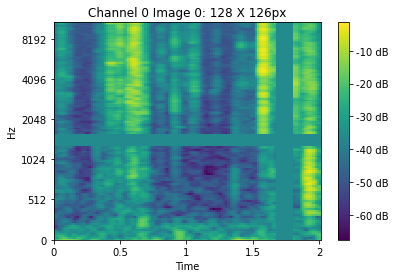

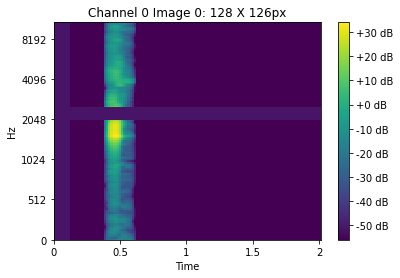

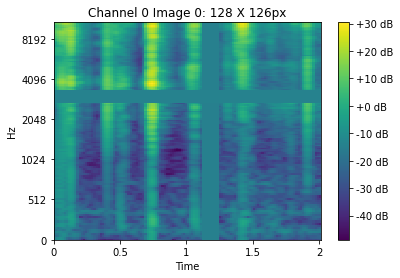

Keys_jangling;Tap
Drip;Raindrop
Crackle


In [ ]:
dls.show_batch(max_n=3)

## Training

Now that we have our `Dataloaders`, we need to make a model. We'll make a function that changes a `Learner`'s first layer to accept a 1 channel input.

Let's make an audio_learner function which is similar to a cnn_learner. In addition, the learner will need the Binary Cross Entropy Loss, so we will need to combine both the approach from the fastai multicat notebook:

https://github.com/fastai/fastbook/blob/master/06_multicat.ipynb

and the fastai2 audio learner creation.

This will need the following steps:



1.   Create a standard CNN Learner
2.   Get the activation sizes from a single mini-batch
3. Pass the activation sizes to the BCELoss Function
4. Pass the BCE Loss function to the `audiolearner` function, which augments the Leaner to accept a single channel input




**Note on Multi-category Loss Function**

Fastbook:

>We also saw that the model in a Learner is generally an object of a class inheriting from nn.Module, and that you can call it using parentheses and it will return the activations of a model. You should pass it your independent variable, as a mini batch. We can try it out by grabbing a mini batch from our DataLoader, and then passing it to the model:

>Note that because we have a one-hot encoded dependent variable, we can't directly use nll_loss or softmax (and therefore we can't use cross_entropy).

>Normally for one-hot encoded targets you'll want F.binary_cross_entropy_with_logits (or nn.BCEWithLogitsLoss), which do both sigmoid and binary cross entropy in a single function, as in our example above.

***With a standard learner, we don't normally need to tell fastai to use this loss function since it will be automatically chosen for us using the DataLoaders recognising multiple category labels. However, as we are creating an audio_learner, we need to provide the loss function to the audio_learner() function defined above.***

>One change compared to the last chapter is the metric we use: since we are in a multilabel problem, we can't use the accuracy function

>The class predicted was the one with the highest activation (this is what argmax does). Here it doesn't work because we could have more than one prediction on a single image. After applying the sigmoid to our activations (to make them between 0 and 1), we need to decide which ones are 0s and which ones are 1s by picking a threshold. Each value above the threshold will be considered as a 1, and each value lower than the threshold will be considered a 0. 

>If we pass accuracy_multi directly as a metric, it will use the default value for threshold, which is 0.5. We might want to adjust that default and create a new version of accuracy_multi that has a different default. 

>Picking a threshold is important. If you pick a threshold that's too low, you'll often be failing to select correctly labelled objects. If you pick a threshold that's too high, you'll often be selecting correctly labelled objects. We can see this by changing our metric, and then calling validate, which returns the validation loss and metrics. 

In this case, we're going to use BCEWithLogitsLossFlat():

```"Same as `nn.CrossEntropyLoss`, but flattens input and target."```

say the fastai docs - double check.

Also, we change the output to be 80 neurons to match the label amount.


### Using an LWL-wrap Metric
For the Kaggle competition the metric used was lwl wrap:

The primary competition metric will be label-weighted label-ranking average precision (lwlrap, pronounced "Lol wrap"). This measures the average precision of retrieving a ranked list of relevant labels for each test clip (i.e., the system ranks all the available labels, then the precisions of the ranked lists down to each true label are averaged). This is a generalization of the mean reciprocal rank measure (used in last year’s edition of the competition) for the case where there can be multiple true labels per test item. The novel "label-weighted" part means that the overall score is the average over all the labels in the test set, where each label receives equal weight (by contrast, plain lrap gives each test item equal weight, thereby discounting the contribution of individual labels when they appear on the same item as multiple other labels).

_We use label weighting because it allows per-class values to be calculated, and still have the overall metric be expressed as simple average of the per-class metrics (weighted by each label's prior in the test set). For participant’s convenience, a Python implementation of lwlrap is provided in this public Google Colab._

An implementation for fastai is also outlined within this competition kernel, used below:

https://www.kaggle.com/daisukelab/cnn-2d-basic-solution-powered-by-fast-ai

In [ ]:
# from official code https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8#scrollTo=cRCaCIb9oguU
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class


# Wrapper for fast.ai library
def lwlrap(scores, truth, **kwargs):
    score, weight = calculate_per_class_lwlrap(to_np(truth), to_np(scores))
    return torch.Tensor([(score * weight).sum()])

### Train our AudioLearner

Below are different options for learners - for experimentation

**see below and use threshold of 0.4 as investigated**

In [ ]:
# for maxblur option
!pip install kornia

In [ ]:
# Adopted from 
# https://discuss.pytorch.org/t/how-can-i-replace-an-intermediate-layer-in-a-pre-trained-network/3586/7
import kornia
def convert_MP_to_blurMP(model, layer_type_old):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_MP_to_blurMP(module, layer_type_old)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = kornia.contrib.MaxBlurPool2d(3, True)
            model._modules[name] = layer_new

    return model

#### Using fastai models

In [ ]:
# ### OPTION 1



# # Custom cnn model created from pretrained xresnet18 (smaller model for inference speed)
# # 1 input channel and 80 output nodes
# # torch.nn.BCEWithLogitsLoss() = Binary Cross Entropy Loss from pytorch
# # accuracy_multi for multi label

# model = create_cnn_model(xresnet18, n_in=1, n_out=80, pretrained=False)

# learn = Learner(dls, model, LabelSmoothingCrossEntropy(), metrics=[partial(accuracy_multi, threshold=0.4), lwlrap], cbs=MixUp) # pass custom model to Learner

In [ ]:
 ### OPTION 2 - SOTA model updates

# Bag of Tricks xresnet18 also incorporating:

# Mish activation fucntion
# Self Attention
# MaxblurPool
# Ranger optimization function

# Custom cnn model created from pretrained xresnet18 (smaller model for inference speed)
# 1 input channel and 80 output nodes
# torch.nn.BCEWithLogitsLoss() = Binary Cross Entropy Loss from pytorch
# accuracy_multi for multi label  
   
   
model = xresnet18(pretrained=False, act_cls=Mish, sa=True, c_in=1, n_out=80) #create custom xresnet: 1 input channel,  80 output nodes, self-attention, Mish activation function
model = convert_MP_to_blurMP(model, nn.MaxPool2d) # convert MaxPool2D layers to MaxBlurPool
learn = Learner(dls, model=model, loss_func=BCEWithLogitsLossFlat(), opt_func = ranger, metrics=[partial(accuracy_multi, thresh=0.5),lwlrap]) # pass custom model to Learner, no mixup for noisy set as fewer epochs

In [ ]:
learn.summary()

epoch,train_loss,valid_loss,accuracy_multi,lwlrap,time


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


XResNet (Input shape: ['64 x 1 x 128 x 126'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 32 x 64 x 63    288        True      
________________________________________________________________
BatchNorm2d          64 x 32 x 64 x 63    64         True      
________________________________________________________________
Mish                 64 x 32 x 64 x 63    0          False     
________________________________________________________________
Conv2d               64 x 32 x 64 x 63    9,216      True      
________________________________________________________________
BatchNorm2d          64 x 32 x 64 x 63    64         True      
________________________________________________________________
Mish                 64 x 32 x 64 x 63    0          False     
________________________________________________________________
Conv2d               64 x 64 x 64 x 63    18,432     True      
____________________________________________________

In [ ]:
# find the learning rate
learn.lr_find()

In [ ]:
# # fit with one_cyle learning rate policy
# learn.fit_one_cycle(10, 3e-2)

#### Pick our threshold (after initial training)

**We can find the best threshold by picking a few threshold levels and seeing what works best in terms of our metric**

This is easy to do if we grab the predictions just once:

In [ ]:
# preds,targs = learn.get_preds()

We can now use a list comprehension approach to test a range of threshold levels using these predictions:

In [ ]:
# xs = torch.linspace(0.05,0.95,100)
# accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
# plt.plot(xs,accs);

In [ ]:
# learn.metrics = partial(accuracy_multi, thresh=0.1)
# learn.validate()

We can find where the maximum accuracy is acheived:

In [ ]:
# np.max(accs)

In [ ]:
# max_acc = np.argmax(accs) # get index of max
# max_acc, xs[max_acc] # find threshold (xs) level of max

So lets use a threshold of 0.3 to 0.4 in our metric and train from scratch:

In [ ]:
# learn = Learner(dls, model, BCEWithLogitsLossFlat(), metrics=partial(accuracy_multi, thresh=0.3), cbs=MixUp) # pass custom model to Learner

In [ ]:
# fit with one_cyle learning rate policy -

# NOTE - MAY NEED TO USE FLAT cosine learning rate with this learner: learn.fit_flat_cos(10, lr=3e-3)
learn.fit_flat_cos(50, 3e-2)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [ ]:
# Save the stage 1 model to allow quick fine tuning experimentation
learn.save('xresnet18-MixUp-stage-1')

In [ ]:
learn.export(fname='/content/drive/My Drive/Machine_Learning/My_Projects/19011 - Audio Classifier Web App/xresne18-sota-50epoch.pkl')

Now let's unfreeze the base model and train on the whole network:

SuggestedLRs(lr_min=0.0005248074419796466, lr_steep=1.3182567499825382e-06)

Exception ignored in: <bound method Wave_write.__del__ of <wave.Wave_write object at 0x7f0704a5dc18>>
Traceback (most recent call last):
  File "/usr/lib/python3.6/wave.py", line 316, in __del__
    self.close()
  File "/usr/lib/python3.6/wave.py", line 434, in close
    self._ensure_header_written(0)
  File "/usr/lib/python3.6/wave.py", line 454, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


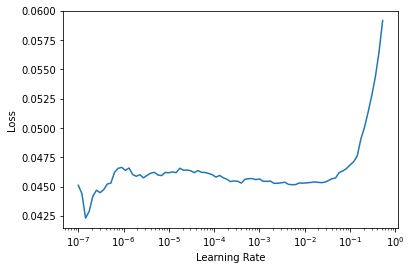

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.045270,0.043581,0.986839,02:43
1,0.045336,0.043702,0.986682,02:33
2,0.044861,0.043016,0.987027,02:29
3,0.044699,0.043359,0.986937,02:29
4,0.043983,0.042624,0.986959,02:29
5,0.043499,0.042228,0.987132,02:31
6,0.042966,0.041789,0.987350,02:30
7,0.042401,0.041726,0.987402,02:31
8,0.042617,0.041362,0.987297,02:30
9,0.042151,0.041444,0.987470,02:30


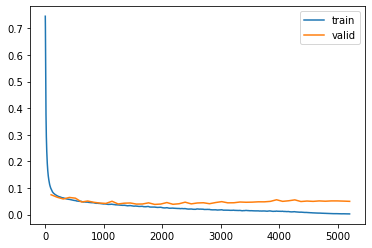

In [ ]:
learn.recorder.plot_loss()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


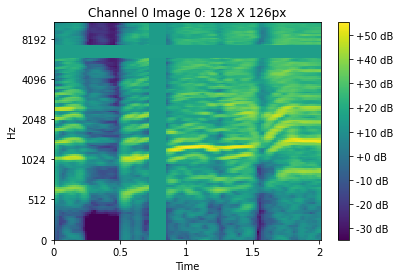

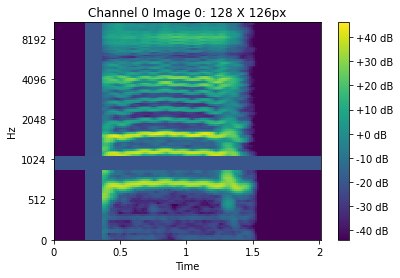

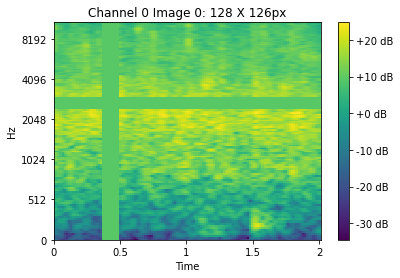

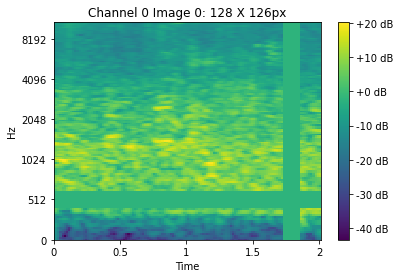

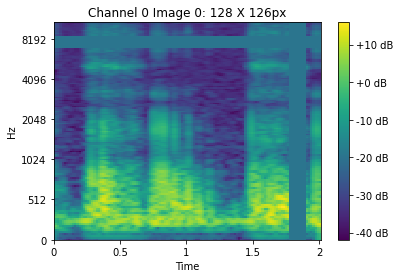

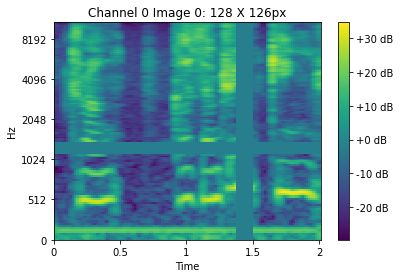

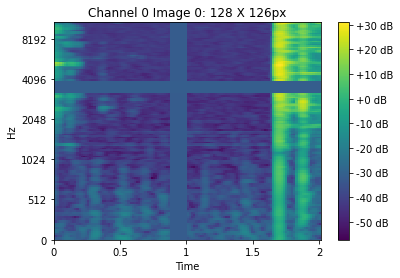

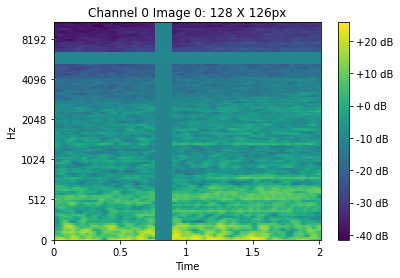

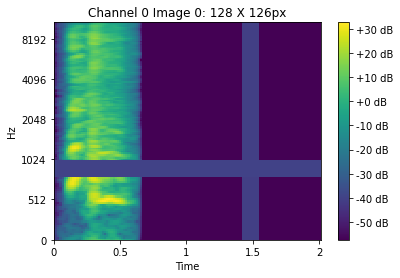

Yell
Male_singing
Applause;Clapping
Bus
Purr
Female_singing
Shatter
Traffic_noise_and_roadway_noise
Sneeze
Yell
Male_singing
Applause
Skateboard
Purr
Female_speech_and_woman_speaking
Shatter
Car_passing_by;Traffic_noise_and_roadway_noise
Female_speech_and_woman_speaking;Sneeze


In [ ]:
learn.show_results()

In [ ]:
# Save the stage 2 model
path = '/content/drive/My Drive/Machine_Learning/My_Projects/19011 - Audio Classifier Web App/xresnet50-pretrained-stage-2-finetuned'
learn.save(file=path, with_opt=True)

### Using PANN models

PANN models are the Pretrained Audio models described in the paper: https://arxiv.org/abs/1912.10211

Trained on Google AudiosSet, we can download them from here:

https://zenodo.org/record/3960586

In [ ]:
!wget https://zenodo.org/record/3960586/files/ResNet22_mAP%3D0.430.pth

--2020-08-17 20:30:20--  https://zenodo.org/record/3960586/files/ResNet22_mAP%3D0.430.pth
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 259135254 (247M) [application/octet-stream]
Saving to: ‘ResNet22_mAP=0.430.pth’

ResNet22_mAP=0.430. 100%[===================>] 247.13M  13.2MB/s    in 18s     

2020-08-17 20:30:40 (13.5 MB/s) - ‘ResNet22_mAP=0.430.pth’ saved [259135254/259135254]



In [ ]:
!pip install timm

     |████████████████████████████████| 225kB 4.8MB/s 


In [ ]:
from timm import create_model

class module from - need to convert to fastai?: https://github.com/qiuqiangkong/audioset_tagging_cnn/blob/8d9999d72b282d2dc50a5b5f668dd91369f853c5/pytorch/models.py

In [ ]:
class ResNet22(nn.Module):
    def __init__(self, sample_rate, window_size, hop_size, mel_bins, fmin, 
        fmax, classes_num):
        
        super(ResNet22, self).__init__()

        self.bn0 = nn.BatchNorm2d(64)

        self.conv_block1 = ConvBlock(in_channels=1, out_channels=64)
        # self.conv_block2 = ConvBlock(in_channels=64, out_channels=64)

        self.resnet = _ResNet(block=_ResnetBasicBlock, layers=[2, 2, 2, 2], zero_init_residual=True)

        self.conv_block_after1 = ConvBlock(in_channels=512, out_channels=2048)

        self.fc1 = nn.Linear(2048, 2048)
        self.fc_audioset = nn.Linear(2048, classes_num, bias=True)

        self.init_weights()

    def init_weights(self):
        init_bn(self.bn0)
        init_layer(self.fc1)
        init_layer(self.fc_audioset)


    def forward(self, input, mixup_lambda=None):
        """
        Input: (batch_size, data_length)"""

        x = self.spectrogram_extractor(input)   # (batch_size, 1, time_steps, freq_bins)
        x = self.logmel_extractor(x)    # (batch_size, 1, time_steps, mel_bins)
        
        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)
        
        if self.training:
            x = self.spec_augmenter(x)

        # Mixup on spectrogram
        if self.training and mixup_lambda is not None:
            x = do_mixup(x, mixup_lambda)
        
        x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training, inplace=True)
        x = self.resnet(x)
        x = F.avg_pool2d(x, kernel_size=(2, 2))
        x = F.dropout(x, p=0.2, training=self.training, inplace=True)
        x = self.conv_block_after1(x, pool_size=(1, 1), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training, inplace=True)
        x = torch.mean(x, dim=3)
        
        (x1, _) = torch.max(x, dim=2)
        x2 = torch.mean(x, dim=2)
        x = x1 + x2
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu_(self.fc1(x))
        embedding = F.dropout(x, p=0.5, training=self.training)
        clipwise_output = torch.sigmoid(self.fc_audioset(x))
        
        output_dict = {'clipwise_output': clipwise_output, 'embedding': embedding}

        return output_dict

In [ ]:
net = learn.load("/content/ResNet22_mAP=0.430")

RuntimeError: ignored

In [ ]:
net = create_cnn_model(arch=
    
    
    
    "/content/ResNet22_mAP=0.430.pth")



model = create_cnn_model(arch=
                         
                         
                         "/content/ResNet22_mAP=0.430.pth")
    
    xresnet50, n_in=1, n_out=80, pretrained=True)

learn = Learner(dls, model, BCEWithLogitsLossFlat(), metrics=accuracy_multi) # pass custom model to Learner

TypeError: ignored

### Confusion Matrix / Data Cleaning

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
# Need Audio Cleaner option (check), equivalent to: 

# cleaner = ImageClassifierCleaner(learn)
# cleaner


In [ ]:
# # unlink cleaned files
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Test Model

Test using standard `predict` and `tta` methods 

In [ ]:
# # load learner for testing if required
learn = load_learner(fname='/content/drive/My Drive/Machine_Learning/My_Projects/19011 - Audio Classifier Web App/xresnet18-mixup-50epoch.pkl')

In [ ]:
# test set info
df_test

,index,fname,labels,usage,freesound_id,license
0,1,/content/FSDKaggle2019.audio_test/4030a4f2.wav,Cupboard_open_or_close,Public,180226,CC-BY
1,4,/content/FSDKaggle2019.audio_test/2d5dcc5d.wav,"Tap,Drawer_open_or_close",Public,245765,CC0
2,6,/content/FSDKaggle2019.audio_test/354d467a.wav,Zipper_(clothing),Public,327688,CC-BY-NC
3,10,/content/FSDKaggle2019.audio_test/00bfaaaf.wav,Gasp,Public,360469,CC0
4,11,/content/FSDKaggle2019.audio_test/12bcd3ec.wav,Cricket,Public,434204,CC0
...,...,...,...,...,...,...
1115,4453,/content/FSDKaggle2019.audio_test/410837eb.wav,Gasp,Public,171942,CC0
1116,4464,/content/FSDKaggle2019.audio_test/1fe639ee.wav,Writing,Public,253901,CC0
1117,4466,/content/FSDKaggle2019.audio_test/0824bbdb.wav,Shatter,Public,171994,CC0
1118,4467,/content/FSDKaggle2019.audio_test/3b0b13f4.wav,Sneeze,Public,81883,CC-BY


### learn.get_preds

In [ ]:
# create test dataloaders
dl_test = learn.dls.test_dl(df_test, with_labels=True)

# predict using get_preds
preds, targs = learn.get_preds(dl=dl_test)

# Create test results DataFrame (for later)
df_test_preds = pd.DataFrame(preds)
df_test_preds.columns = learn.dls.vocab
df_test_preds.insert(0, "fname", 0)
df_test_preds.fname = df_test.fname

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [ ]:
dl_test.dataset.items.fname

0       /content/FSDKaggle2019.audio_test/4030a4f2.wav
1       /content/FSDKaggle2019.audio_test/2d5dcc5d.wav
2       /content/FSDKaggle2019.audio_test/354d467a.wav
3       /content/FSDKaggle2019.audio_test/00bfaaaf.wav
4       /content/FSDKaggle2019.audio_test/12bcd3ec.wav
                             ...                      
1115    /content/FSDKaggle2019.audio_test/410837eb.wav
1116    /content/FSDKaggle2019.audio_test/1fe639ee.wav
1117    /content/FSDKaggle2019.audio_test/0824bbdb.wav
1118    /content/FSDKaggle2019.audio_test/3b0b13f4.wav
1119    /content/FSDKaggle2019.audio_test/39a8ac5c.wav
Name: fname, Length: 1120, dtype: object

In [ ]:
dl_test.dataset.items.labels

0         Cupboard_open_or_close
1       Tap,Drawer_open_or_close
2              Zipper_(clothing)
3                           Gasp
4                        Cricket
                  ...           
1115                        Gasp
1116                     Writing
1117                     Shatter
1118                      Sneeze
1119                     Shatter
Name: labels, Length: 1120, dtype: object

Let's see the multi-label accuracy with chosen threshold:

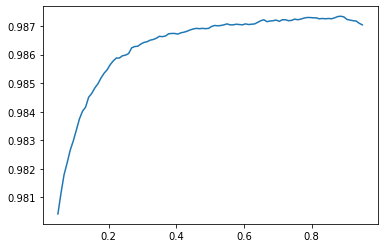

In [ ]:
# let's see the accuracy over threshold range

xs = torch.linspace(0.05,0.95,100)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [ ]:
max_acc = np.argmax(accs) # get index of max
max_acc, xs[max_acc] # find threshold (xs) level of max

(92, tensor(0.8864))

In [ ]:
accuracy_multi(preds, targs, thresh=0.3, sigmoid=False).item()

0.9864062666893005

Now using an lwlrap metric:

In [ ]:
lwlrap(preds, targs).item()

0.6566401124000549

From fastai forum https://forums.fast.ai/t/fastai-v2-recipes-tips-and-tricks-wiki/64486/3

We can also store the `test_dl` object in the DataLoaders dls object as a second validation DataLoader like this:

In [ ]:
dls.loaders.append(dl)

then use it to display the corresponding "most confused" classes:

In [ ]:
interp = ClassificationInterpretation.from_learner(learn, ds_idx=2)
interp.plot_most_confused()

### TTA

Now see the performance using test-time augmentations:

In [ ]:
# # create test dataloaders
dl_test = learn.dls.test_dl(df_test, with_labels=True)

# predict using get_preds
with learn.no_bar(): # fix progressbar error
    preds_tta, targs_tta = learn.tta(dl=dl_test)

# # Create test results DataFrame   
# df_test_preds = pd.DataFrame(preds)
# df_test_preds.columns = learn.dls.vocab
# df_test_preds.insert(0, "fname", 0)
# df_test_preds.fname = test_files
# df_test_preds.head()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [ ]:
preds_tta

tensor([[4.0859e-05, 1.9829e-04, 8.3801e-07,  ..., 8.0371e-05, 6.1180e-05,
         3.3545e-01],
        [2.5008e-05, 1.1615e-06, 2.3289e-08,  ..., 2.1162e-03, 7.8133e-08,
         7.8015e-05],
        [1.7360e-07, 4.0516e-07, 1.4140e-11,  ..., 5.7135e-02, 2.0824e-03,
         9.3486e-01],
        ...,
        [3.3194e-07, 1.0805e-09, 3.2467e-12,  ..., 9.7775e-10, 3.2975e-07,
         2.4314e-07],
        [1.1036e-09, 1.3681e-13, 7.1284e-12,  ..., 2.9489e-10, 7.7202e-08,
         6.1604e-13],
        [1.9771e-06, 1.1092e-05, 2.9404e-08,  ..., 8.9127e-05, 2.2064e-03,
         2.4611e-04]])

Let's see the multi-label accuracy with chosen threshold:

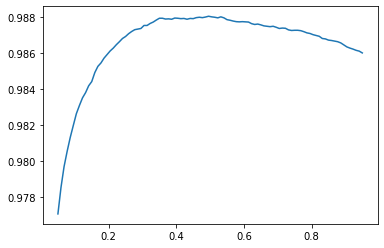

In [ ]:
# let's see the accuracy over threshold range

xs = torch.linspace(0.05,0.95,100)
accs = [accuracy_multi(preds_tta, targs_tta, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [ ]:
max_acc = np.argmax(accs) # get index of max
max_acc, xs[max_acc] # find threshold (xs) level of max

(49, tensor(0.4955))

In [ ]:
accuracy_multi(preds_tta, targs_tta, thresh=0.9).item()

0.9824665188789368

with lwlrap:

In [ ]:
lwlrap(preds_tta, targs_tta)

tensor([0.6973])

### Inference speed testing

Now let's test the inference, taken from here: https://colab.research.google.com/drive/1Z6VIRZ_sX314hyev3Gm5gBqvm1wQVo-a#scrollTo=xuKJ4wBU6gxx

In [ ]:
!pip install ffmpeg-python

In [ ]:
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import scipy
from IPython.display import Audio

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
audio, sr = get_audio()

In [ ]:
# write the file

inf_filepath = "test-file.wav"
scipy.io.wavfile.write(inf_filepath, sr, audio)

In [ ]:
# listen to the file (check)
Audio(inf_filepath)

#### Using learn.predict

In [ ]:
# # try learn.predict
thresh = 0.2
prediction,_,preds =  learn.predict(inf_filepath)

In [ ]:
# Classification using threshold
learn.dls.vocab[np.argwhere(preds > thresh).squeeze()]

(#2) ['Male_singing','Male_speech_and_man_speaking']

In [ ]:
# Ordered Classifications (descending)
learn.dls.vocab[np.argsort(preds).squeeze()][::-1]

(#80) ['Male_singing','Male_speech_and_man_speaking','Female_speech_and_woman_speaking','Yell','Female_singing','Toilet_flush','Crowd','Bus','Trickle_and_dribble','Cheering'...]

In [ ]:
# Ordered Classification probabilities (descending)
L(np.rint((np.sort(preds).squeeze()[::-1])*100))

(#1) [array([89., 50.,  3.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.], dtype=float32)]

#### Using TTA

In [ ]:
# predict using tta

df_inf_tta = pd.DataFrame(data=[inf_filepath], columns=["fname"])
df_inf_tta
dl_inf_tta = learn.dls.test_dl(df_inf_tta, with_labels=False)
dl_inf_tta.dataset

(#1) [(AudioTensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0223,  0.0157,  0.0118]]),)]

In [ ]:
predsinf_tta, targsinf_tta = learn.tta(dl=dl_inf_tta)

epoch,train_loss,valid_loss,accuracy_multi,time


AttributeError: ignored

In [ ]:
# Classification using threshold
thresh = 0.1

learn.dls.vocab[np.argwhere(predsinf_tta.squeeze() > thresh).squeeze()]

(#3) ['Female_speech_and_woman_speaking','Male_singing','Male_speech_and_man_speaking']

In [ ]:
# Ordered Classifications (descending)
learn.dls.vocab[np.argsort(predsinf_tta).squeeze()][::-1]

(#80) ['Female_speech_and_woman_speaking','Male_singing','Male_speech_and_man_speaking','Burping_and_eructation','Fart','Yell','Marimba_and_xylophone','Gurgling','Bass_guitar','Female_singing'...]

In [ ]:
# Ordered Classification probabilities (descending)

L(np.rint((np.sort(predsinf_tta).squeeze()[::-1])*100))

(#1) [array([23., 21., 13.,  4.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.], dtype=float32)]

## Export Learner

### Google Drive

In [ ]:
# Export Model
learn.export(fname='/content/drive/My Drive/Machine_Learning/My_Projects/19011 - Audio Classifier Web App/xresnet50-pretrained-20epoch.pkl')

### Google Cloud Bucket


In [ ]:
from google.colab import auth
auth.authenticate_user()

# set project id
project_id = 'fastai2-audio-app-mf-ct'
!gcloud config set project {project_id}

# bucket name
bucket_name = 'fastai-export-bucket'

# copy to our bucket
!gsutil cp "/content/drive/My Drive/Machine_Learning/My_Projects/19011 - Audio Classifier Web App/xresne18-mixup-50epoch.pkl" gs://{bucket_name}/

Updated property [core/project].
Copying file:///content/drive/My Drive/Machine_Learning/My_Projects/19011 - Audio Classifier Web App/xresne18-mixup-50epoch.pkl [Content-Type=application/octet-stream]...
- [1 files][ 48.7 MiB/ 48.7 MiB]                                                
Operation completed over 1 objects/48.7 MiB.                                     


In [ ]:
list(learn.dls.vocab)

['Accelerating_and_revving_and_vroom',
 'Accordion',
 'Acoustic_guitar',
 'Applause',
 'Bark',
 'Bass_drum',
 'Bass_guitar',
 'Bathtub_(filling_or_washing)',
 'Bicycle_bell',
 'Burping_and_eructation',
 'Bus',
 'Buzz',
 'Car_passing_by',
 'Cheering',
 'Chewing_and_mastication',
 'Child_speech_and_kid_speaking',
 'Chink_and_clink',
 'Chirp_and_tweet',
 'Church_bell',
 'Clapping',
 'Computer_keyboard',
 'Crackle',
 'Cricket',
 'Crowd',
 'Cupboard_open_or_close',
 'Cutlery_and_silverware',
 'Dishes_and_pots_and_pans',
 'Drawer_open_or_close',
 'Drip',
 'Electric_guitar',
 'Fart',
 'Female_singing',
 'Female_speech_and_woman_speaking',
 'Fill_(with_liquid)',
 'Finger_snapping',
 'Frying_(food)',
 'Gasp',
 'Glockenspiel',
 'Gong',
 'Gurgling',
 'Harmonica',
 'Hi-hat',
 'Hiss',
 'Keys_jangling',
 'Knock',
 'Male_singing',
 'Male_speech_and_man_speaking',
 'Marimba_and_xylophone',
 'Mechanical_fan',
 'Meow',
 'Microwave_oven',
 'Motorcycle',
 'Printer',
 'Purr',
 'Race_car_and_auto_racing',
 

## List dependencies for render.com requirements.txt:

In [ ]:
# check all dependencies for deployment requirements.txt on Render.com

!pip list

Package                       Version        
----------------------------- ---------------
absl-py                       0.9.0          
alabaster                     0.7.12         
albumentations                0.1.12         
altair                        4.1.0          
argon2-cffi                   20.1.0         
asgiref                       3.2.10         
astor                         0.8.1          
astropy                       4.0.1.post1    
astunparse                    1.6.3          
atari-py                      0.2.6          
atomicwrites                  1.4.0          
attrs                         19.3.0         
audioread                     2.1.8          
autograd                      1.3            
Babel                         2.8.0          
backcall                      0.2.0          
beautifulsoup4                4.6.3          
bleach                        3.1.5          
blis                          0.4.1          
bokeh                         2.1.

In [ ]:
!pip install fastprogress

In [ ]:
python --version